In [1]:
import sklearn.mixture
import numpy as np
import scipy as sp
from keras import Input
from keras.layers   import Dense, Lambda, Layer, Activation
from keras.models   import Model
from keras.layers.normalization import BatchNormalization
import keras.backend as K
import matplotlib.pyplot as plt
import autograd.numpy.random as npr
import pylab
from keras                   import backend
from sklearn.metrics         import adjusted_rand_score
%matplotlib inline
from sklearn.metrics import accuracy_score


/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)

    features = npr.randn(num_classes*num_per_class, 2) \
        * np.array([radial_std, tangential_std])
    features[:,0] += 1.
    labels    = np.repeat(np.arange(num_classes), num_per_class)

    angles    = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1, 2, 2))

    return 10*np.einsum('ti,tij->tj', features, rotations),labels

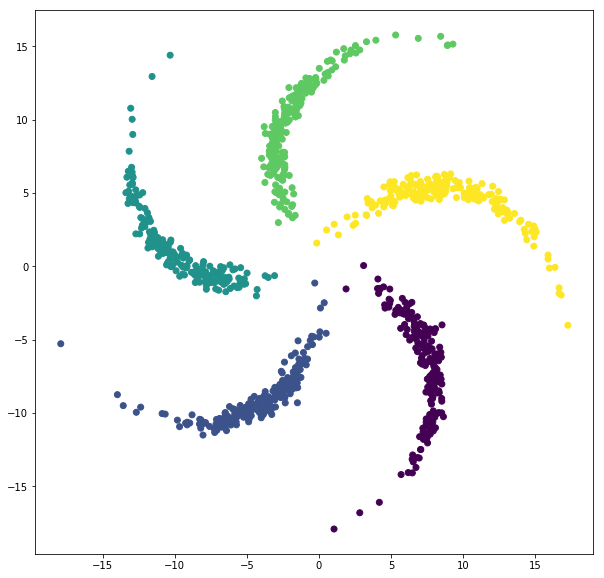

In [3]:
num_clusters        = 5      # number of clusters in pinwheel data
samples_per_cluster = 200    # number of samples per cluster in pinwheel
K = 15                       # number of components in mixture model
N = 2                        # number of latent dimensions
P = 2                        # number of observation dimensions
batch_size          = num_clusters * samples_per_cluster
data, label = make_pinwheel_data(0.3, 0.05, num_clusters, samples_per_cluster, 0.25)

plt.figure(figsize=(10,10))
pylab.scatter(data[:,0],data[:,1],c=label)

In [4]:
def vae_loss(y_true, y_pred):
    # 入力と出力の交差エントロピー
    xent_loss =   backend.sum((backend.square(y_true - y_mean))/(backend.exp(y_log_var)) + backend.log(np.pi * 2) + y_log_var, axis=-1) * 0.5
    # 事前分布と事後分布のKL情報量
    kl_loss   =   backend.sum((backend.square(z - z_mean))/(backend.exp(z_log_var)) + backend.log(np.pi * 2) + z_log_var, axis=-1) * 0.5
    return backend.mean(xent_loss  - kl_loss - gmm_loss)


def sampling(args):
    mean, log_var = args
    epsilon = backend.random_normal(shape=backend.shape(mean), mean=0.,stddev=1.)
    return mean + backend.exp(log_var / 2) * epsilon

In [5]:
original_dim      = data.shape[1]
intermediate_dim  = 100
latent_dim        = 2

x                 = Input(shape=(original_dim,))
gmm_loss          = Input(shape=(1,))

decoder           = Dense(intermediate_dim)(x)
decoder           = BatchNormalization()(decoder)
decoder           = Activation('tanh')(decoder)



z_mean            = Dense(latent_dim,activation='linear')(decoder)
z_log_var         = Dense(latent_dim,activation='linear')(decoder)

z                 = Lambda(sampling,   output_shape=(latent_dim,))([z_mean, z_log_var])

decoder           = Dense(intermediate_dim)(z)
decoder           = BatchNormalization()(decoder)
decoder           = Activation('tanh')(decoder)


y_mean            = Dense(original_dim,activation='linear')(decoder)
y_log_var         = Dense(original_dim,activation='linear')(decoder)

y                 = Lambda(sampling, output_shape=(original_dim,))([y_mean, y_log_var])

VAE               = Model(input=[x,gmm_loss], output=y)
VAE_latent        = Model(input=x, output=z)

VAE_latent_mean   = Model(input=x, output=z_mean)
VAE_latent_var    = Model(input=x, output=z_log_var)
VAE_predict_mean  = Model(input=x, output=y_mean)
VAE_predict_var   = Model(input=x, output=y_log_var)

VAE.compile(optimizer='adam', loss=vae_loss)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          300         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100)          400         dense_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 100)          0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dense_2 (D

/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("la...)`
/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWa

In [6]:
epoch  = 500
latent = VAE_latent.predict(data)
gmm    = sklearn.mixture.GaussianMixture(n_components=num_clusters, covariance_type='full', max_iter=1)
for i in range(1):
    gmm.fit(latent)
liklyhood  = gmm.predict_proba(latent)

for i in range(epoch):
    latent_old = latent
    weigth_old = VAE.get_weights()
    loss   = VAE.train_on_batch([data,np.log(liklyhood+0.0001).sum(1)],data)
    latent = VAE_latent.predict(data)
    gmm.fit(latent)
    liklyhood = gmm.predict_proba(latent)
    print(i,loss,adjusted_rand_score(gmm.predict(latent),label),np.log(liklyhood+0.0001).sum(1).mean())

    

/Users/tomohiromimura/.pyenv/versions/3.6.4/envs/normal/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


0 80.073845 0.10029509917990291 -19.4649388685809
1 73.56839 0.12728580541637521 -22.895362113819598
2 76.29915 0.11725824663390656 -21.782635478004337
3 72.11231 0.13723882297817558 -21.190611281311956
4 69.0449 0.15557832701455054 -22.27651186361334
5 68.60113 0.1446814096602739 -20.693550669197336
6 65.12147 0.1755795082364556 -22.387591582938406
7 64.83948 0.20074067050853836 -22.634426035813682
8 63.57032 0.22175771174020398 -22.007306952466173
9 62.103054 0.23970193893170139 -22.856615505375157
10 61.37952 0.2716411941769255 -23.123939894867704
11 60.998917 0.213957267801811 -23.237180374767995
12 59.721546 0.293657243749029 -24.019598882274288
13 59.657124 0.33678553356193164 -22.947786996787325
14 57.531258 0.32645823014523556 -23.106216326972934
15 56.403923 0.3721788320930316 -24.593608240059083
16 57.443855 0.3874980983639336 -24.29736168377185
17 55.919575 0.3997032517197245 -25.54940009097257
18 56.33043 0.42369985940976446 -25.03798553196704
19 55.022346 0.453769395406384

163 37.30518 0.922199710336429 -35.29971670958931
164 37.393566 0.9363052874929503 -35.17339595438605
165 37.205128 0.9483235277115306 -35.13650128079073
166 37.19975 0.9506202303154495 -35.23369117762391
167 37.261177 0.9312373879286833 -35.182692255328504
168 37.165806 0.9483421561044779 -35.25431544678544
169 37.31982 0.9318383572015211 -35.432780770115336
170 37.520004 0.9533029830948507 -35.032027771797424
171 37.103474 0.9458529630141089 -35.440965633661754
172 37.513668 0.960411278578838 -35.13592248534212
173 37.201874 0.9364307819516382 -35.164520010765976
174 37.21773 0.9410457754889883 -35.2848377383621
175 37.243454 0.9435475963666798 -35.242228874388864
176 37.275105 0.9384986354241801 -35.117104785626736
177 37.13505 0.9459659615606512 -35.047525164169976
178 37.03548 0.9554611759673299 -35.27715092049231
179 37.251755 0.9582564743946329 -34.992605796346105
180 36.976875 0.9506858355272697 -35.26421941796611
181 37.229767 0.953233430739883 -35.26776324133924
182 37.27441 

322 36.81645 0.9411513183110273 -35.380321970632515
323 36.715496 0.92913128479415 -35.54388430300448
324 36.9316 0.9337552031909817 -35.50297679105522
325 36.81767 0.960557240526206 -35.50261408577781
326 36.83154 0.9411887979793364 -35.408657941490404
327 36.76953 0.9482766778537433 -35.61881368220764
328 36.890945 0.953408304444593 -35.45672799505142
329 36.8079 0.9507615056555044 -35.47516706886998
330 36.79979 0.9531706820893261 -35.37979760464516
331 36.698933 0.9434277386845541 -35.55432050549916
332 36.899734 0.9508303430374749 -35.45675405133372
333 36.745403 0.950859676716924 -35.60058645153852
334 36.886543 0.953204352892047 -35.217554703758736
335 36.502003 0.9314758201997582 -35.419581066005954
336 36.66867 0.9411354909124974 -35.21035243850782
337 36.521755 0.9509824195434491 -35.528076139792844
338 36.84277 0.9508870020091288 -35.63389015793089
339 36.965504 0.96040321302608 -35.427869436893594
340 36.71306 0.9485276705609919 -35.23791649756909
341 36.465862 0.6768717935

482 35.58106 0.9531694465276241 -35.19240977307889
483 35.84637 0.9410606375203459 -34.904538461954026
484 35.589886 0.9555422454271011 -35.23699724273696
485 35.88276 0.9531279966164108 -34.99264243518931
486 35.708492 0.9409062209087288 -35.01656179676947
487 35.639107 0.9480813714002972 -35.0085177238061
488 35.731663 0.9436932888170342 -35.22711821483547
489 35.87983 0.9459635139590117 -34.9809923587373
490 35.67111 0.6812852276320244 -34.32600998017429
491 34.969296 0.9458918386247164 -35.07667612246735
492 35.69549 0.9338646365339074 -35.2480547298156
493 35.885033 0.9531104115330824 -35.04889524085852
494 35.707798 0.9266438756388633 -35.23670115698941
495 35.846245 0.938601372541624 -35.20418245484872
496 35.873703 0.9410498681508421 -34.95156650367615
497 35.624294 0.9387491924321988 -34.80328666939913
498 35.435856 0.9336086511157827 -34.51037352314803
499 35.180233 0.9481660791750025 -34.86274916899882


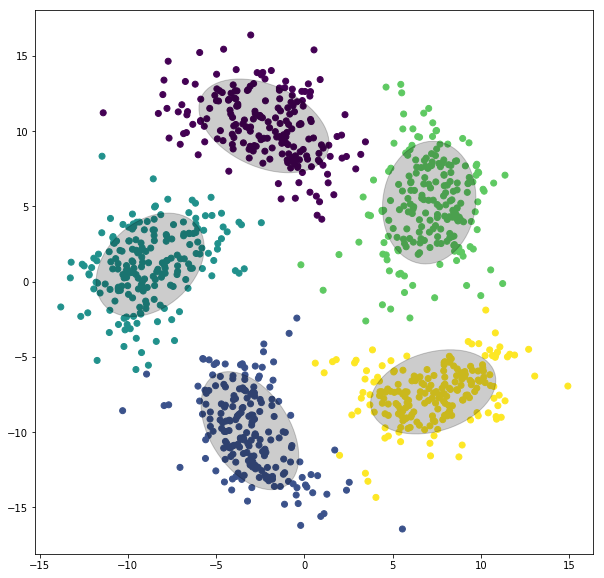

In [7]:
import matplotlib as mpl

plt.figure(figsize=(10,10))
ax = plt.axes()
for n in set(gmm.predict(latent)):
    covariances = gmm.covariances_[n][:2, :2]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                              180 + angle, color='k')
    ell.set_alpha(0.2)
    ax.add_patch(ell)
    
pylab.scatter(latent[:,0],latent[:,1],c=gmm.predict(latent))




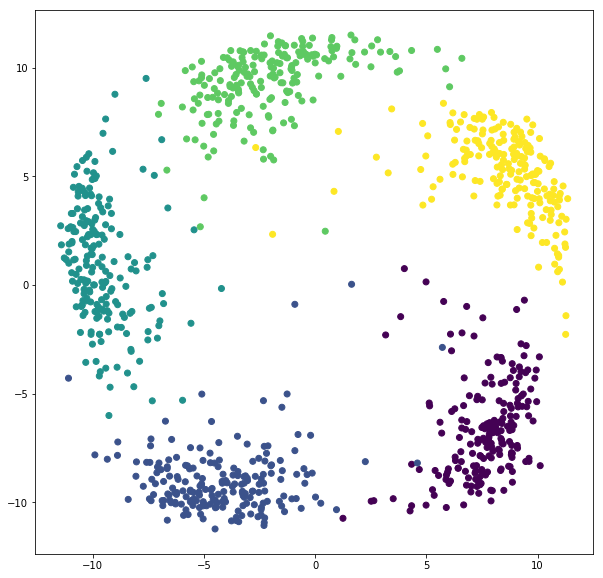

In [8]:
plt.figure(figsize=(10,10))
pylab.scatter(VAE_predict_mean.predict(data)[:,0],VAE_predict_mean.predict(data)[:,1],c=label)


In [9]:
gmm.predict(latent)

array([4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [10]:
import pandas as pd
result  = gmm.predict(latent)
df      = pd.DataFrame({ 'result' : gmm.predict(latent),'label' : label})
iremono = np.zeros((5,5))
for i in range(5):
    acc = df[df['label']==i]
    for j in range(5):
        iremono[i,j] = len(acc[acc['result']==j])
acc = iremono.max(1).sum()/len(label)
print(acc)   

0.979
